<center><img src="/images/gat/thumbnail.jpg"></center>

::: {.column-margin}
Find a lot more architectures and applications using graph neural networks in my book, [**Hands-On Graph Neural Networks**](https://mlabonne.github.io/blog/book.html) 👇
<a href="https://packt.link/a/9781804617526"><img src="/images/gnnbook/cover.png" alt="Hands-On Graph Neural Networks Using Python" id="gnn-book"></a>
:::

Graph Attention Networks (GATs) are one of the most popular types of Graph Neural Networks.

Instead of calculating static weights based on node degrees like Graph Convolutional Networks (GCNs), they assign dynamic weights to node features through a process called **self-attention**. The main idea behind GATs is that some neighbors are more important than others, regardless of their node degrees.

<center><img src="/images/gat/graph_attention_empty.png" width="400">

<i>Node 4 is more important than node 3, which is more important than node 2</i></center></br>

In this article, we will see how to calculate these attention scores and implement an efficient GAT in PyTorch Geometric (PyG). You can run the code of this tutorial with the following [Google Colab notebook](https://colab.research.google.com/drive/1B0vLpH_gSfrOLgsc2UZVyXrcofzA-t0L?usp=sharing).

In [4]:
# Install PyTorch Geometric
import torch
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Numpy for matrices
import numpy as np
np.random.seed(0)

# Visualization
import networkx as nx
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 24})

## 🌐 I. Graph data

<center><img alt="CiteSeer" src="/images/gat/citeseer_yed.png" width="800">

<i>CiteSeer dataset</i></center></br>

Let's perform a node classification task with a GAT. We can use three classic graph datasets (MIT license) for this work. They represent networks of research papers, where each connection is a citation.

* [**Cora**](http://www.kamalnigam.com/papers/cora-jnl.pdf): it consists of 2,708 machine learning papers that belong to one of seven categories. ➡️ Node features represent the presence (1) or absence (0) of 1,433 words in a paper (binary [bag of words](https://en.wikipedia.org/wiki/Bag-of-words_model)).
* [**CiteSeer**](https://clgiles.ist.psu.edu/papers/DL-1998-citeseer.pdf): it is a bigger but similar dataset of 3,327 scientific papers to classify into one of six categories. ➡️ Node features represent the presence (1) or absence (0) of 3,703 words in a paper.
* [**PubMed**](http://eliassi.org/papers/ai-mag-tr08.pdf): it is an even bigger dataset with 19,717 scientific publications about diabetes from PubMed's database, classified into three categories.
➡️ Node features are [TF-IDF weighted word vector](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) from a dictionary of 500 unique words.

These datasets have been widely used by the scientific community. As a challenge, we can compare our accuracy scores to those obtained in the [literature](https://arxiv.org/pdf/1710.10903.pdf) (with standard deviation) using **Multilayer Perceptrons** (MLPs), **GCNs**, and **GATs**:

| Dataset | 📝Cora | 📝CiteSeer | 📝PubMed |
| :--- | :---: | :---: | :---: |
| MLP | 55.1% | 46.5% | 71.4% |
| GCN | 81.4 ± 0.5% | 70.9% ± 0.5% | **79.0%** ± 0.3% |
| GAT | **83.0%** ± 0.7% | **72.5%** ± 0.7% | **79.0%** ± 0.3% |

PubMed is quite large, so it would take longer to process and train a GNN on it. On the other hand, Cora is the most studied one in the literature, so let's focus on **CiteSeer** as a middle ground.

We can directly import any of these datasets in PyTorch Geometric with the [Planetoid class](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.Planetoid):

In [3]:
from torch_geometric.datasets import Planetoid

# Import dataset from PyTorch Geometric
dataset = Planetoid(root=".", name="CiteSeer")
data = dataset[0]

# Print information about the dataset
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')

Number of graphs: 1
Number of nodes: 3327
Number of features: 3703
Number of classes: 6
Has isolated nodes: True


The CiteSeer dataset correctly exhibits the characteristics we previously described. However, **some nodes are isolated** (48 to be precise)! Correctly classifying these isolated nodes will be a challenge since we cannot rely on any aggregation. This is how an MLP processes nodes: it cannot consider the adjacency matrix, which decreases its accuracy.

Let's plot the number of connections of each node with `degree`:

<BarContainer object of 32 artists>

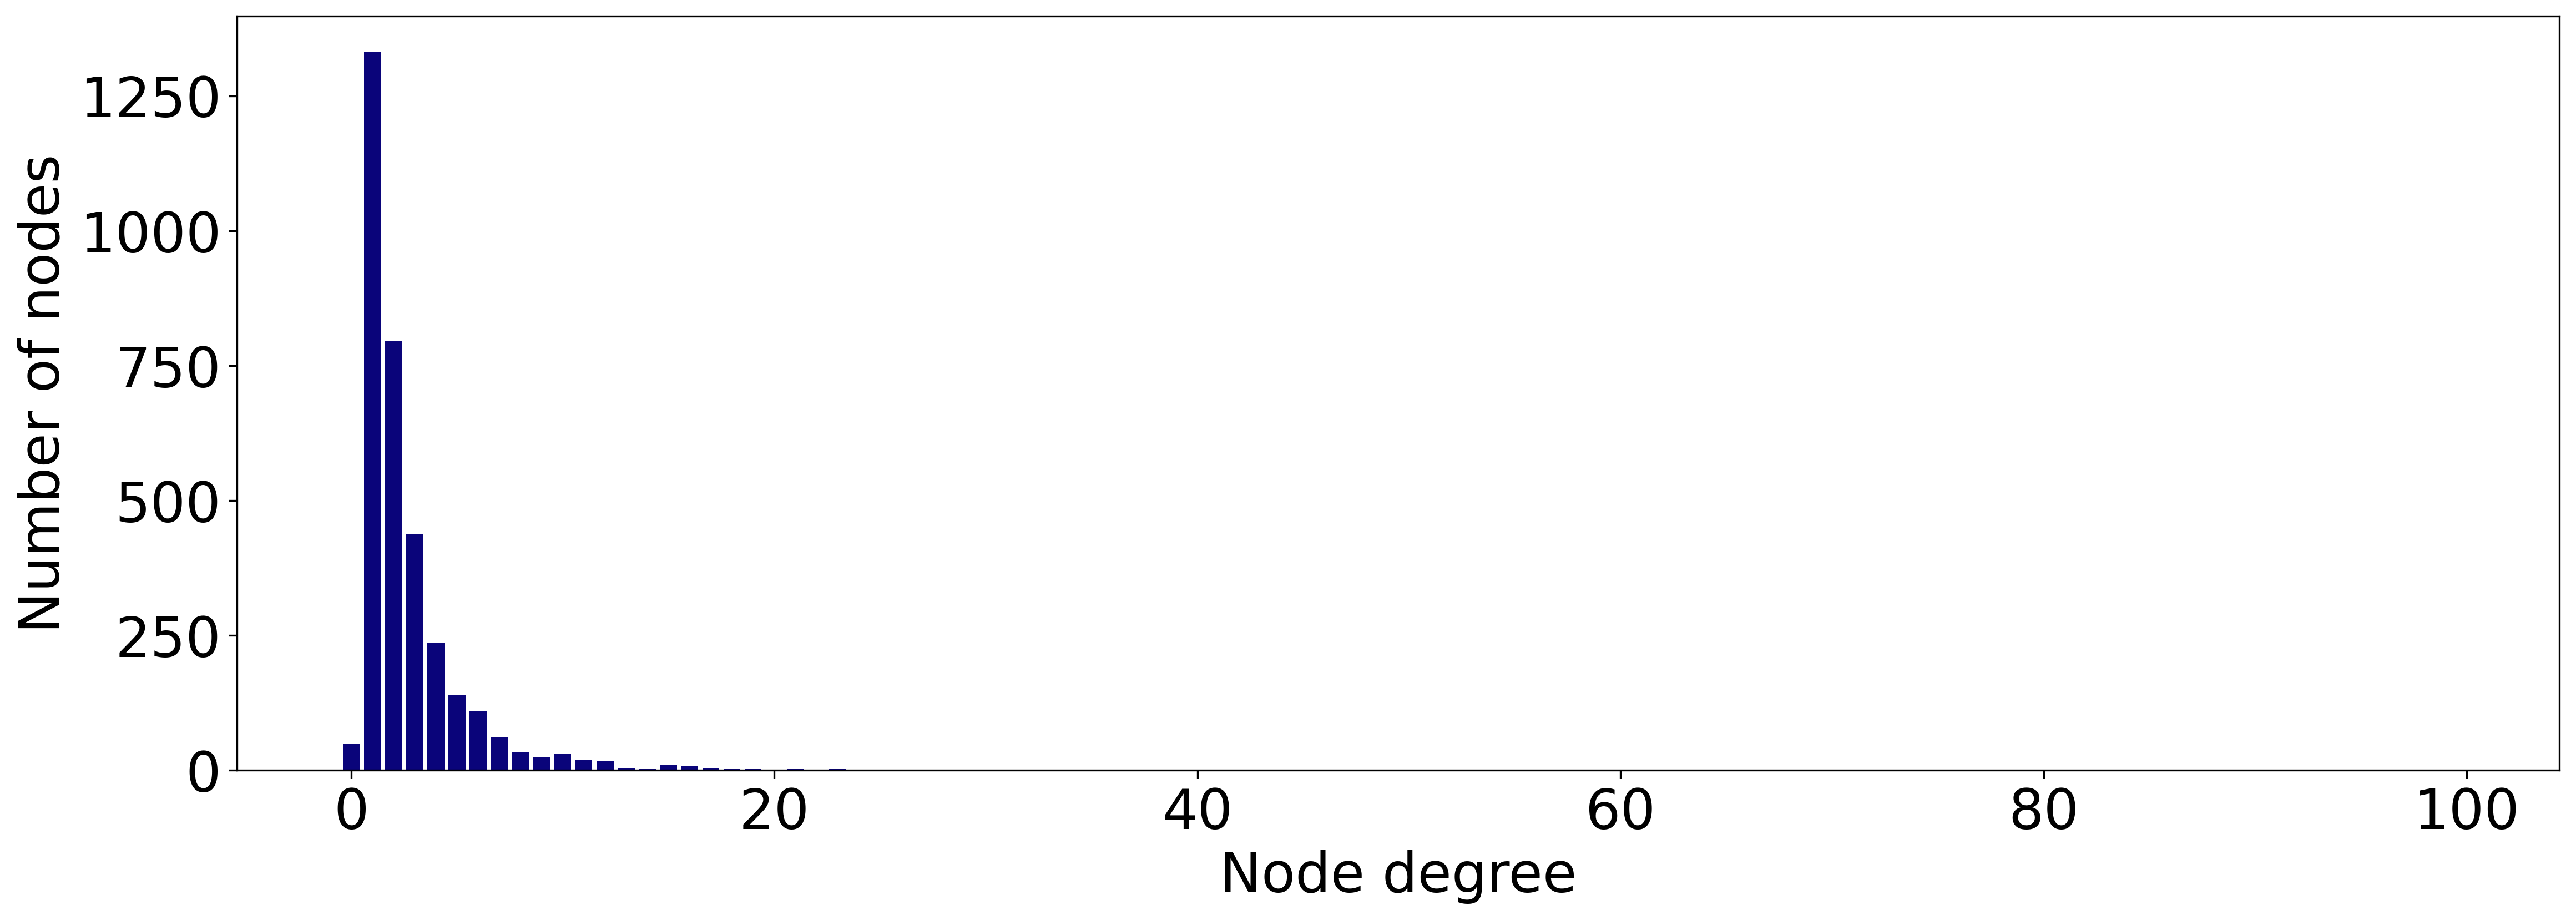

In [7]:
from torch_geometric.utils import degree
from collections import Counter

# Get the list of degrees for each node
degrees = degree(data.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots(figsize=(18, 6))
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(),
        numbers.values(),
        color='#0A047A')

Most nodes only have **1 or 2 neighbors**. It could explain why CiteSeer obtains lower accuracy scores than the two other datasets…

## ⚠️ II. Graph Attention Layer

Introduced by [Veličković et al.](https://arxiv.org/abs/1710.10903) in 2017, self-attention in GATs relies on a simple idea: **some nodes are more important than others**. In this context, we talk about *self*-attention (and not just attention) because inputs are compared to each other.

<center><img src="/images/gat/graph_attention.png" width="400"></center>

In the previous figure, self-attention calculates the importance of nodes 2, 3, and 4's features to node 1. We denote $\alpha_{ij}$ the importance of node $j$'s features to node $i$.

Each node $i$ has an attribute vector $x_i$. The GAT layer calculates the embedding of node 1 as a sum of attention coefficients multiplied by a shared weight matrix $\mathbf{W}$ :

$$h_i = \alpha_{11}\mathbf{W}x_1 + \alpha_{12}\mathbf{W}x_2 + \alpha_{13}\mathbf{W}x_3 + \alpha_{14}\mathbf{W}x_4$$

But how do we calculate these attention coefficients? We could write a static formula, but there's a smarter solution: we can learn their values with a neural network. There are four steps in this process:

1. Linear transformation
2. Activation function
3. Softmax normalization
4. Multi-head attention

### 1. Linear transformation

To calculate the attention coefficient, we need to consider pairs of nodes. An easy way to create these pairs is to concatenate attribute vectors from both nodes.

Then, we can apply a new **linear transformation** with a weight matrix $W_{att}$:

$$a_{ij} = W_{att}^t[\mathbf{W}x_i\mathbin\Vert \mathbf{W}x_j]$$

<center><img src="/images/gat/attention_calculation1.png" height="400"></center>

### 2. Activation function

We're building a neural network, so the second step is to add nonlinearity with an activation function. In this case, the paper's authors chose the $\text{LeakyReLU}$ function.

$$e_{ij} = \text{LeakyReLU}(a_{ij})$$

<center><img src="/images/gat/attention_calculation2.png" height="400"></center>

### 3. Softmax normalization

The output of our neural network is **not normalized**, which is a problem since we want to compare these coefficients. For example, to be able to say if node 2 is more important to node 1 than node 3 ($\alpha_{12} > \alpha_{13}$), we need to use the same scale.

A common way to do it with neural networks is to use the softmax function. Here, we apply it to every neighboring node, including the target node itself:

$$\alpha_{ij} = \text{softmax}_j(e_{ij}) = \frac{exp(e_{ij})}{\sum_{k \in \mathcal{N}_i}{exp(e_{ik})}}$$

<center><img src="/images/gat/attention_calculation3.png" height="400"></center>

This equation produces the final attention coefficients $\alpha_{ij}$. The only problem is... **self-attention is not very stable**. In order to improve performance, [Vaswani et al.](https://arxiv.org/abs/1706.03762) introduced multi-head attention in the transformer architecture.

### 4. Multi-head attention

This should not be a big surprise if you're familiar with the transformer architecture, but [transformers are a special case of GNNs](https://thegradient.pub/transformers-are-graph-neural-networks/). This is why GATs look so much like a simplified version of transformers. The good thing is that we can reuse some ideas from Natural Language Processing here, like multi-head attention.

<center><img src="/images/gat/attention_calculation4.png" height="400"></center>

In GATs, multi-head attention consists of **replicating the same three steps several times** in order to average or concatenate the results. Instead of a single embedding $h_1$, we get one embedding per attention head (denoted $h_1^k$ for the head $k$). One of the two following schemes can then be applied:

* **Average**: we sum the different $h_i^k$ and normalize the result by the number of attention heads $n$;

$$h_i = \frac{1}{n}\sum_{k=1}^n{h_i^k}$$

* **Concatenation**: we concatenate the different $h_i^k$.

$$h_i = \mathbin\Vert_{k=1}^n{h_i^k}$$

In practice, we use the **concatenation scheme** when it's a hidden layer and the **average scheme** when it's the last (output) layer. Most of the time, we will stack several GAT layers to aggregate a larger neighborhood and thus combine these two schemes in the same GAT model.

## 🧠 III. Implementing a Graph Attention Network

Let's now implement a GAT in PyTorch Geometric. This library has two different graph attention layers: `GATConv` and `GATv2Conv`.

The layer we talked about in the previous section is the `GatConv` layer, but in 2021 [Brody et al.](https://arxiv.org/abs/2105.14491) introduced an improved layer by modifying the order of operations. In `Gatv2Conv`, the weight matrix $\mathbf{W}$ is applied after the concatenation and the attention weight matrix $W_{att}$ after the $\text{LeakyReLU}$ function. In summary:

* `GatConv`: $e_{ij} = \text{LeakyReLU}(W_{att}^t[\mathbf{W}x_i\mathbin\Vert \mathbf{W}x_j])$
* `Gatv2Conv`: $e_{ij} = W_{att}^t \text{LeakyReLU}(\mathbf{W}[x_i\mathbin\Vert x_j])$

Which one should you use? According to the authors, `Gatv2Conv` consistently outperforms `GatConv` and thus should be preferred. We'll follow their advice and implement this improved layer in our example.

Okay, let's classify the papers from CiteSeer! I tried to (roughly) reproduce the experiments of the original authors without adding too much complexity. You can find the official implementation of GAT [on GitHub](https://github.com/PetarV-/GAT).

Note that we use graph attention layers in two configurations:

* The **first layer** concatenates **8 outputs** (multi-head attention);
* The **second layer** only has **1 head**, which produces our final embeddings.

We're also going to train and test a GCN with two GCN layers (and dropout) to compare the accuracy scores.

In [63]:
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv


class GCN(torch.nn.Module):
    """Graph Convolutional Network"""
    def __init__(self, dim_in, dim_h, dim_out):
      super().__init__()
      self.gcn1 = GCNConv(dim_in, dim_h)
      self.gcn2 = GCNConv(dim_h, dim_out)
      self.optimizer = torch.optim.Adam(self.parameters(),
                                        lr=0.01,
                                        weight_decay=5e-4)

    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.5, training=self.training)
        h = self.gcn1(h, edge_index).relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.gcn2(h, edge_index)
        return h, F.log_softmax(h, dim=1)


class GAT(torch.nn.Module):
    """Graph Attention Network"""
    def __init__(self, dim_in, dim_h, dim_out, heads=8):
        super().__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
        self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)
        self.optimizer = torch.optim.Adam(self.parameters(),
                                          lr=0.005,
                                          weight_decay=5e-4)

    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.6, training=self.training)
        h = self.gat1(h, edge_index)
        h = F.elu(h)
        h = F.dropout(h, p=0.6, training=self.training)
        h = self.gat2(h, edge_index)
        return h, F.log_softmax(h, dim=1)

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

def train(model, data):
    """Train a GNN model and return the trained model."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer
    epochs = 200

    model.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        _, out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')
          
    return model

@torch.no_grad()
def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

In [64]:
%%time
# Create GCN model
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)

# Train and test
train(gcn, data)
acc = test(gcn, data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(3703, 16)
  (gcn2): GCNConv(16, 6)
)
Epoch   0 | Train Loss: 1.782 | Train Acc:  20.83% | Val Loss: 1.79 | Val Acc: 17.40%
Epoch  10 | Train Loss: 0.580 | Train Acc:  89.17% | Val Loss: 1.31 | Val Acc: 55.40%
Epoch  20 | Train Loss: 0.165 | Train Acc:  95.00% | Val Loss: 1.30 | Val Acc: 56.20%
Epoch  30 | Train Loss: 0.113 | Train Acc:  97.50% | Val Loss: 1.49 | Val Acc: 54.40%
Epoch  40 | Train Loss: 0.069 | Train Acc:  99.17% | Val Loss: 1.66 | Val Acc: 54.60%
Epoch  50 | Train Loss: 0.037 | Train Acc: 100.00% | Val Loss: 1.65 | Val Acc: 55.60%
Epoch  60 | Train Loss: 0.053 | Train Acc:  99.17% | Val Loss: 1.50 | Val Acc: 56.60%
Epoch  70 | Train Loss: 0.084 | Train Acc:  97.50% | Val Loss: 1.50 | Val Acc: 58.00%
Epoch  80 | Train Loss: 0.054 | Train Acc: 100.00% | Val Loss: 1.67 | Val Acc: 54.40%
Epoch  90 | Train Loss: 0.048 | Train Acc:  98.33% | Val Loss: 1.54 | Val Acc: 57.80%
Epoch 100 | Train Loss: 0.062 | Train Acc:  99.17% | Val Loss: 1.62 | Val Acc: 5

In [65]:
%%time
# Create GAT model
gat = GAT(dataset.num_features, 8, dataset.num_classes)
print(gat)

# Train and test
train(gat, data)
acc = test(gat, data)
print(f'\nGAT test accuracy: {acc*100:.2f}%\n')

GAT(
  (gat1): GATv2Conv(3703, 8, heads=8)
  (gat2): GATv2Conv(64, 6, heads=1)
)
Epoch   0 | Train Loss: 1.790 | Train Acc:  17.50% | Val Loss: 1.81 | Val Acc: 12.80%
Epoch  10 | Train Loss: 0.114 | Train Acc:  96.67% | Val Loss: 1.05 | Val Acc: 67.20%
Epoch  20 | Train Loss: 0.040 | Train Acc:  98.33% | Val Loss: 1.21 | Val Acc: 64.80%
Epoch  30 | Train Loss: 0.021 | Train Acc:  99.17% | Val Loss: 1.30 | Val Acc: 65.80%
Epoch  40 | Train Loss: 0.027 | Train Acc:  99.17% | Val Loss: 1.20 | Val Acc: 67.20%
Epoch  50 | Train Loss: 0.012 | Train Acc:  99.17% | Val Loss: 1.18 | Val Acc: 67.20%
Epoch  60 | Train Loss: 0.009 | Train Acc: 100.00% | Val Loss: 1.11 | Val Acc: 67.00%
Epoch  70 | Train Loss: 0.007 | Train Acc: 100.00% | Val Loss: 1.19 | Val Acc: 64.80%
Epoch  80 | Train Loss: 0.013 | Train Acc: 100.00% | Val Loss: 1.16 | Val Acc: 66.80%
Epoch  90 | Train Loss: 0.009 | Train Acc: 100.00% | Val Loss: 1.10 | Val Acc: 66.60%
Epoch 100 | Train Loss: 0.013 | Train Acc: 100.00% | Val Lo

This experiment is not super rigorous: we'd need to repeat it $n$ times and report the average accuracy with a standard deviation as the final result.

In this example, we can see that the **GAT outperforms the GCN** in terms of accuracy (70.00% vs. 67.70%), but takes longer to train (55.9s vs. 32.4s). It's a tradeoff that can cause scalability issues when working with large graphs.

The authors obtained 72.5% for the GAT and 70.3% for the GCN, which is significantly better than what we got. The difference can be explained by additional preprocessing steps, some tweaks in the models, and a different training setting (e.g., a patience of 100 instead of a fixed number of epochs). We kept the code as simple as possible here, but feel free to modify it to improve the results.

Beyond the accuracy score, it is interesting to see what the GAT actually learned. We can visualize it with [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) plot, a powerful method to plot high-dimensional data in 2D or 3D. First, let's see what the embeddings looked like before any training: it should be random since they're produced by randomly initialized weight matrices.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


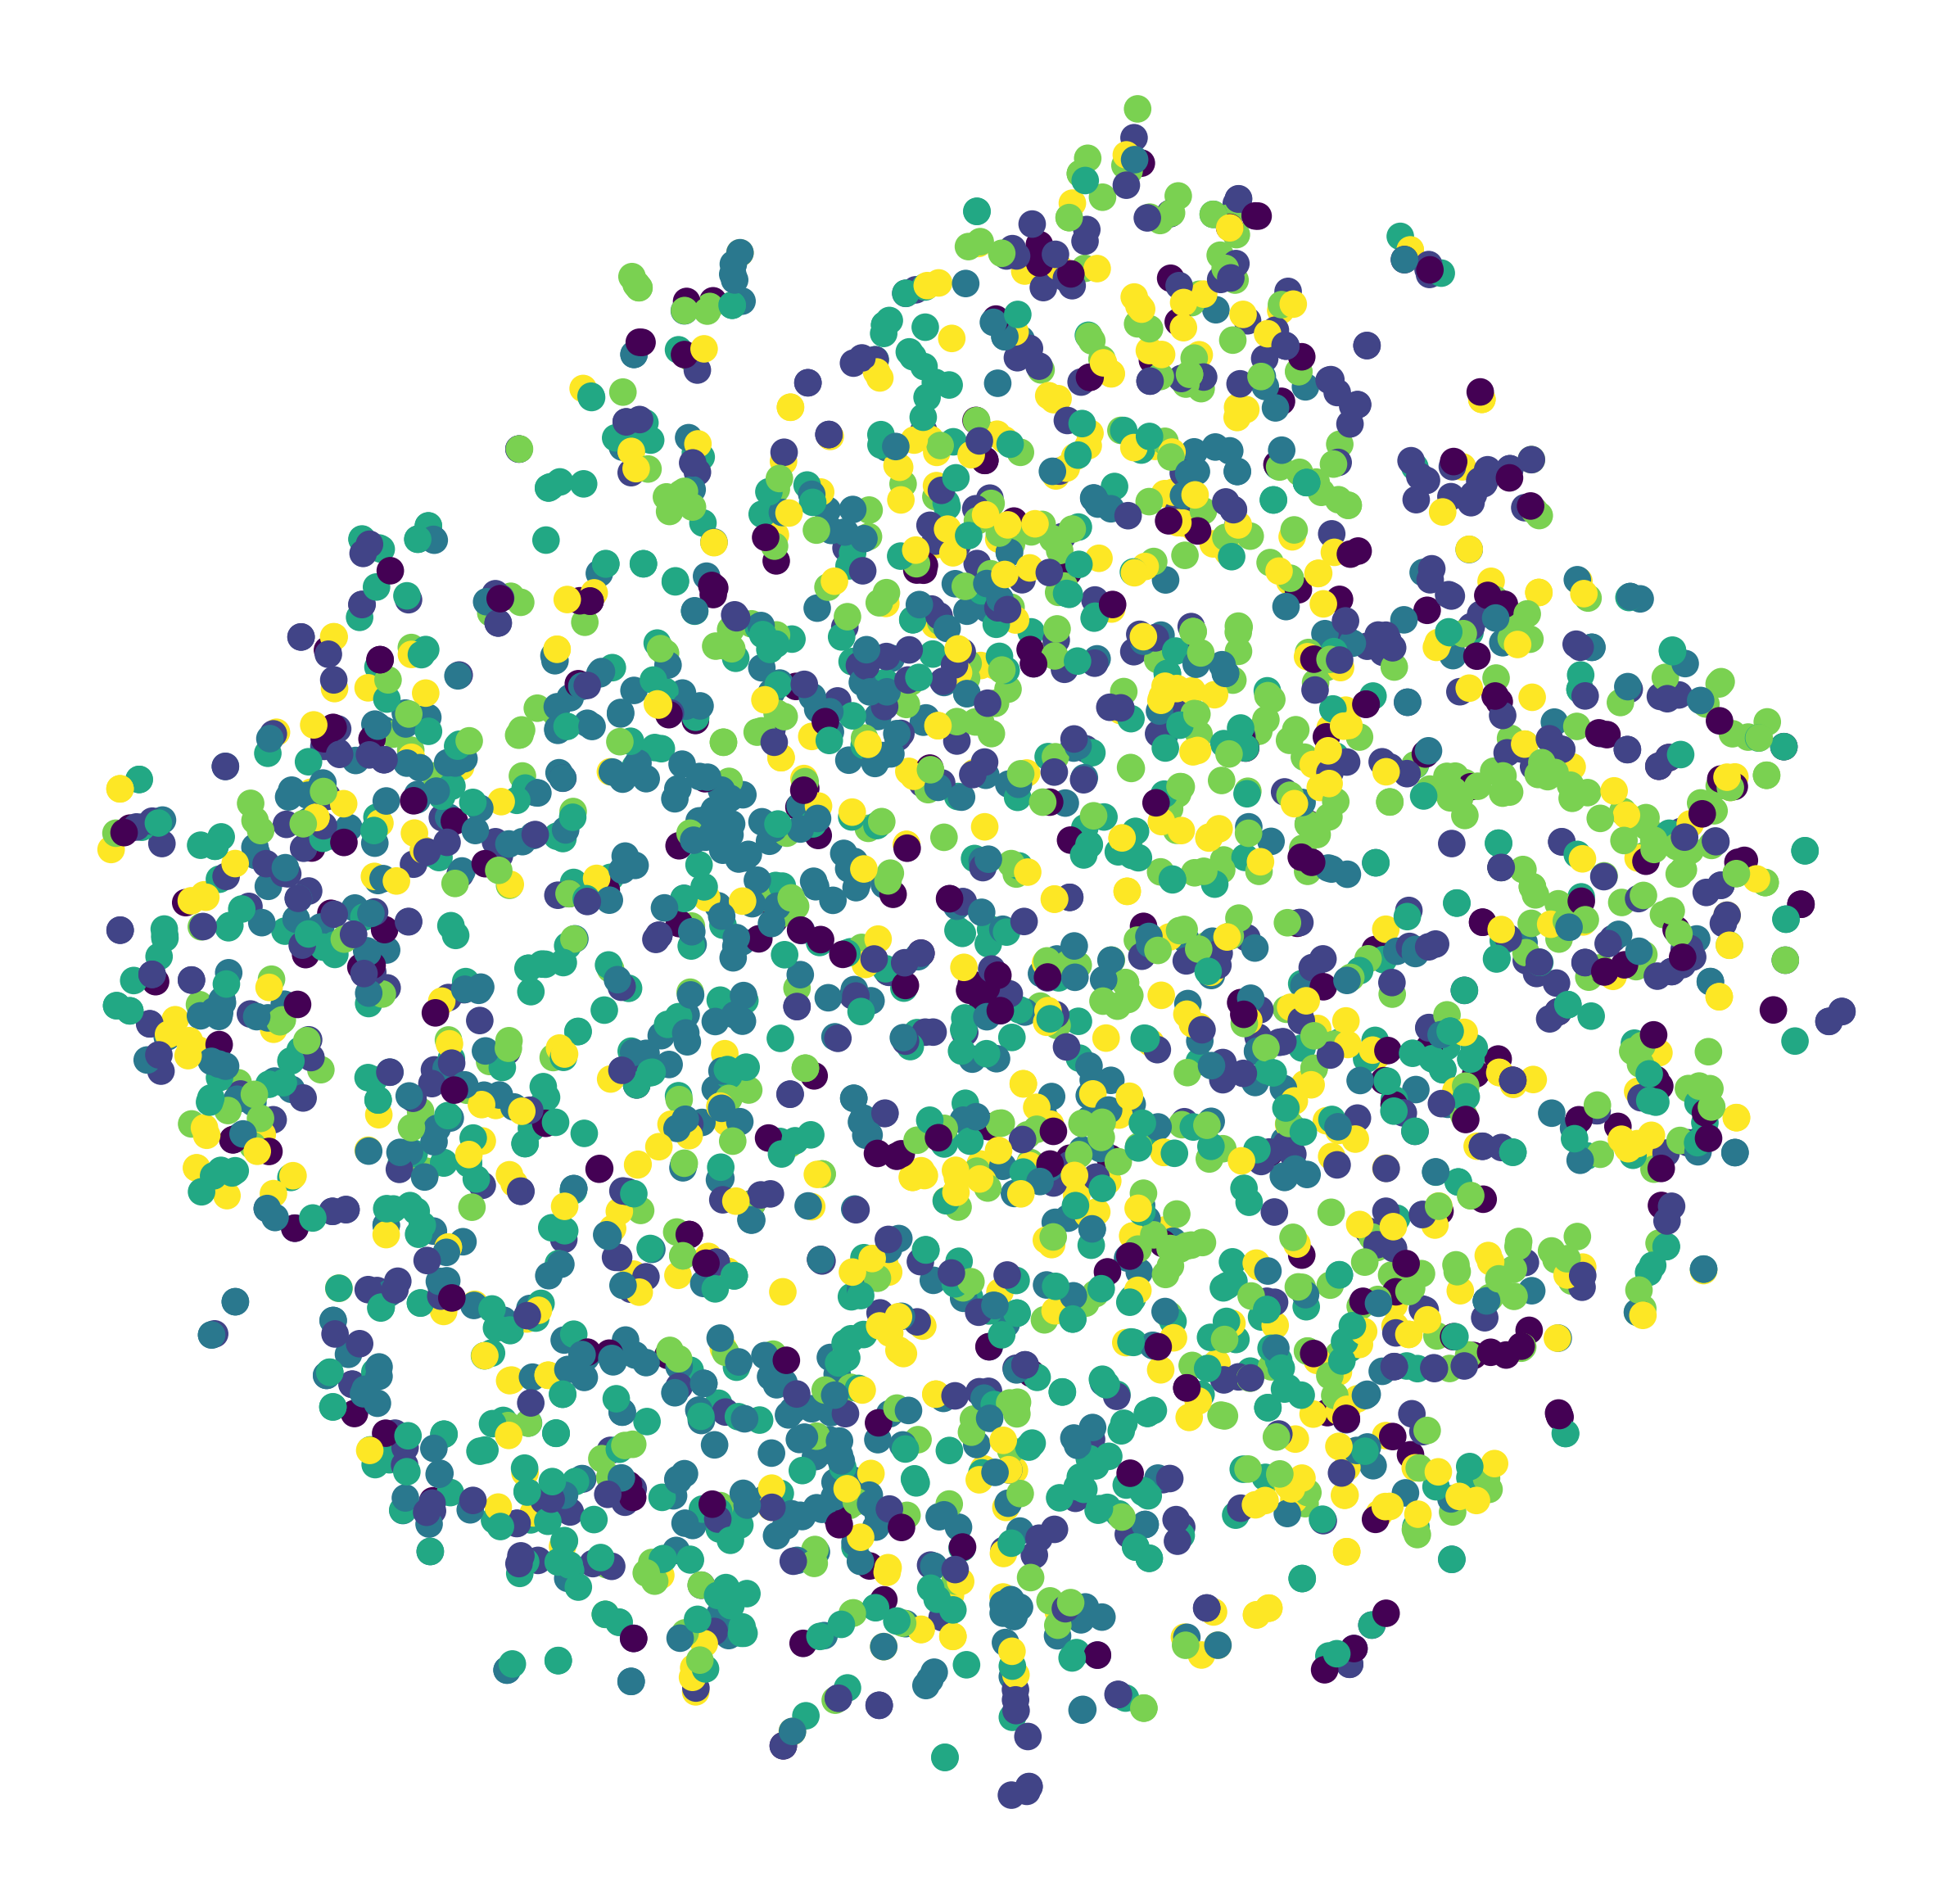

In [66]:
# Initialize new untrained model
untrained_gat = GAT(dataset.num_features, 8, dataset.num_classes)

# Get embeddings
h, _ = untrained_gat(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()

Indeed, there's no apparent structure. But do the embeddings produced by our trained model look better?

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


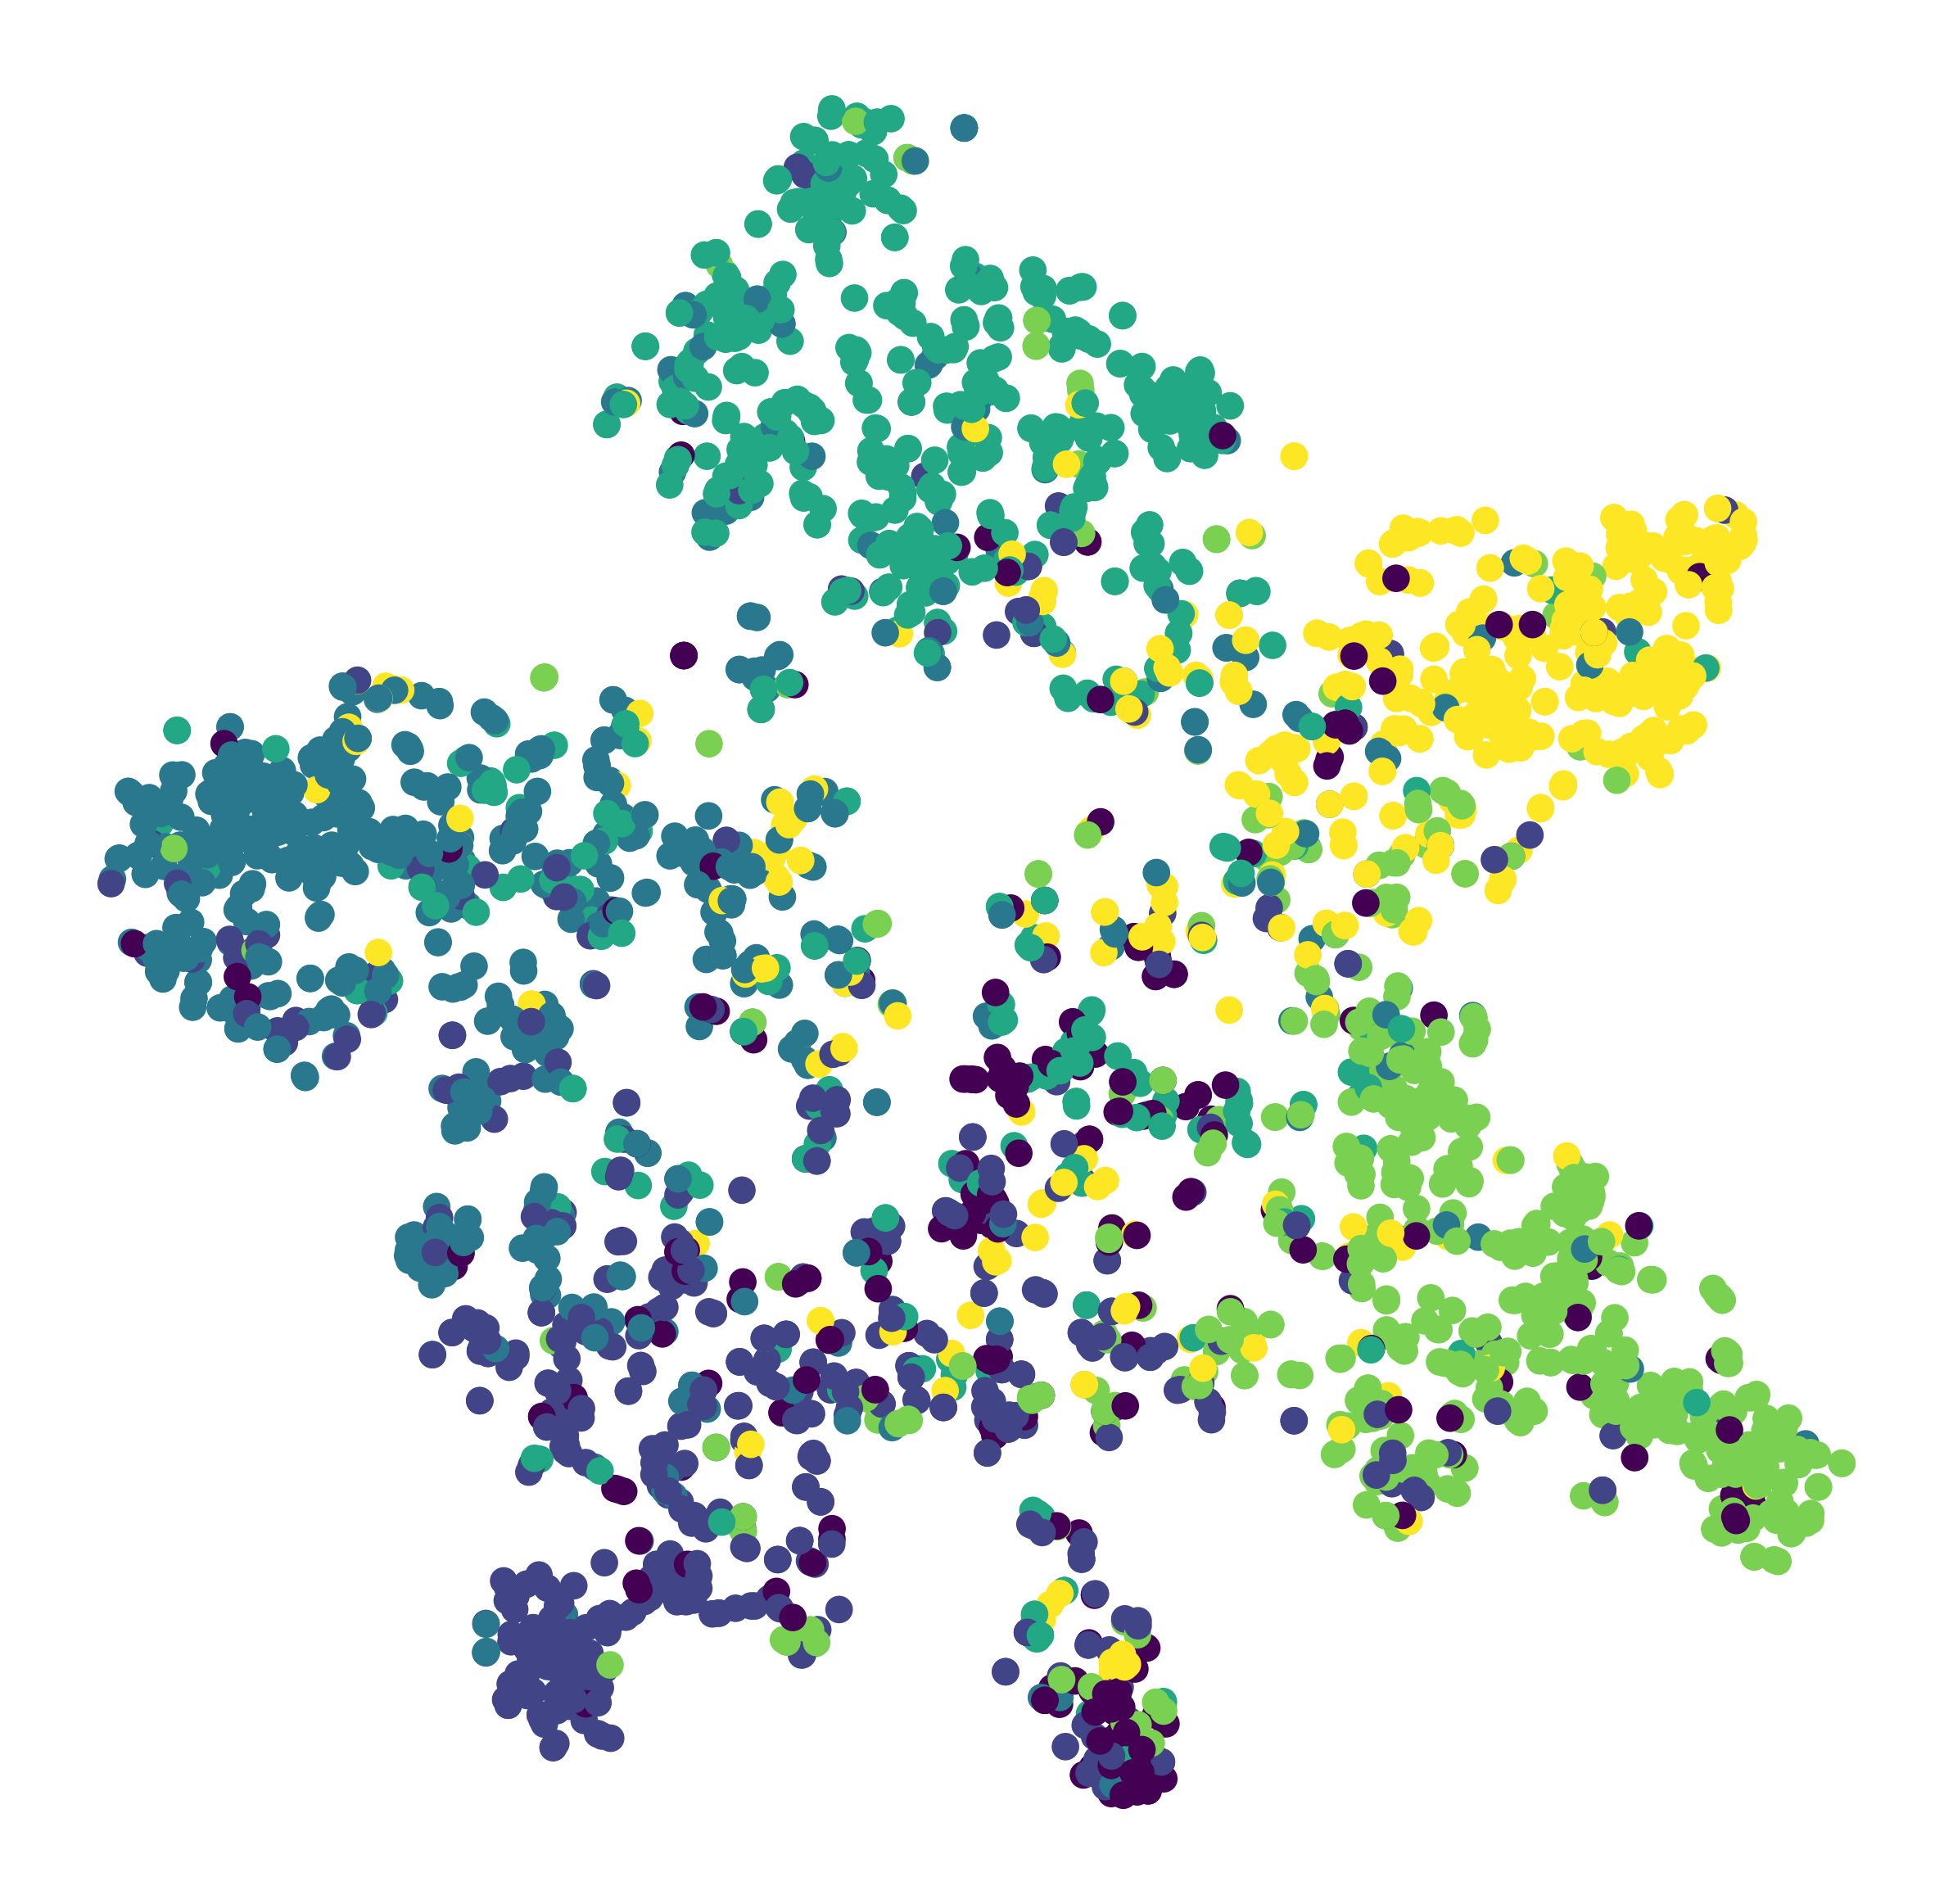

In [67]:
# Get embeddings
h, _ = gat(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()

The difference is noticeable: **nodes belonging to the same classes cluster together**. We can see six clusters, corresponding to the six classes of papers. There are outliers, but this was to be expected: our accuracy score is far from perfect.

Previously, I speculated that poorly connected nodes might **negatively impact** performance on CiteSeer. So let's verify that by calculating the model's accuracy for each degree.

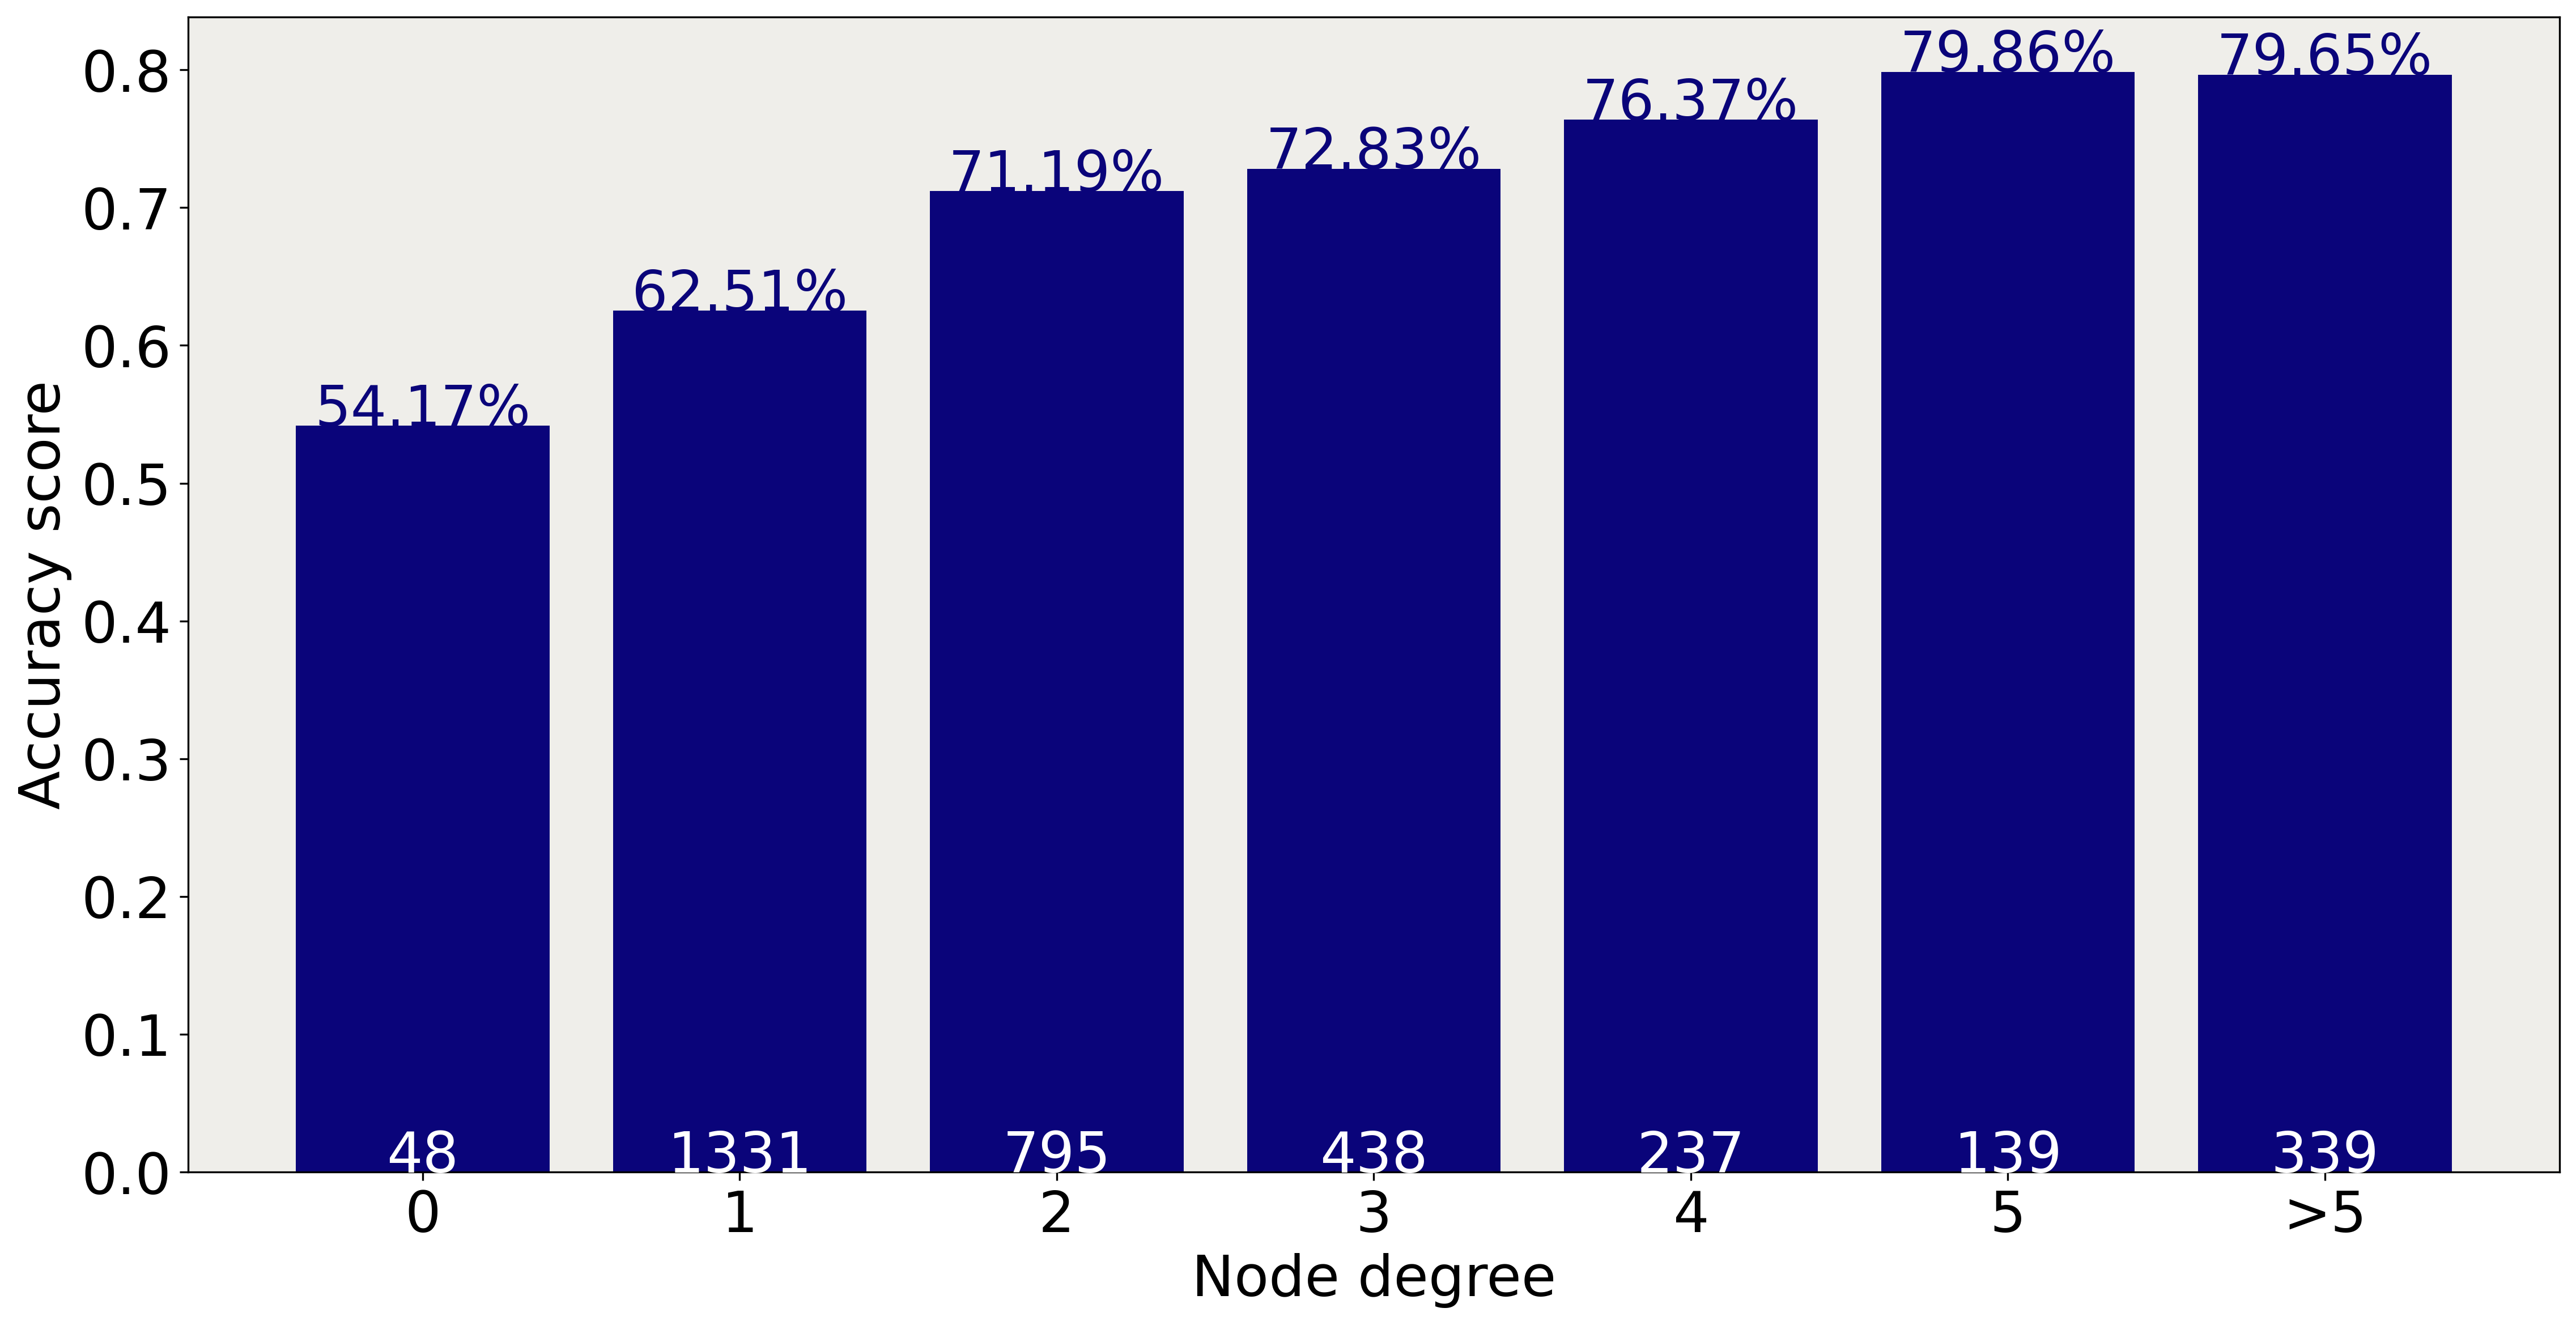

In [68]:
from torch_geometric.utils import degree

# Get model's classifications
_, out = gat(data.x, data.edge_index)

# Calculate the degree of each node
degrees = degree(data.edge_index[0]).numpy()

# Store accuracy scores and sample sizes
accuracies = []
sizes = []

# Accuracy for degrees between 0 and 5
for i in range(0, 6):
  mask = np.where(degrees == i)[0]
  accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
  sizes.append(len(mask))

# Accuracy for degrees > 5
mask = np.where(degrees > 5)[0]
accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
sizes.append(len(mask))

# Bar plot
fig, ax = plt.subplots(figsize=(18, 9))
ax.set_xlabel('Node degree')
ax.set_ylabel('Accuracy score')
ax.set_facecolor('#EFEEEA')
plt.bar(['0','1','2','3','4','5','>5'],
        accuracies,
        color='#0A047A')
for i in range(0, 7):
    plt.text(i, accuracies[i], f'{accuracies[i]*100:.2f}%',
             ha='center', color='#0A047A')
for i in range(0, 7):
    plt.text(i, accuracies[i]//2, sizes[i],
             ha='center', color='white')

These results confirm our intuition: nodes with few neighbors are indeed **harder to classify**. This is due to the nature of GNNs: the more relevant connections you have, the more information you can aggregate.

## Conclusion

While they take longer to train, GATs often provide a substantial improvement over GCNs in terms of accuracy. The self-attention mechanism automatically calculates weights instead of static coefficients to produce better embeddings. In this article,

* We learned how to calculate dynamic weights using self-attention
* We implemented and compared two architectures (a GCN and a GAT) in PyTorch Geometric
* We visualized what the GAT learned with a t-SNE plot and the accuracy score for each degree

GATs are a standard architecture in a lot of GNN applications. However, their slow training time can become a problem when applied to massive graph datasets. Scalability is an important factor in deep learning: more data can often lead to better performance.

In the next article, we'll see how to improve scalability with mini-batching and a new GNN architecture, called GraphSAGE.

If you enjoyed this tutorial, feel free to **[follow me on Twitter](https://twitter.com/maximelabonne)** for more GNN content. Thank you, and see you in the next article! 📣

## 🌐 Graph Neural Network Course

<a href="https://github.com/mlabonne/Graph-Neural-Network-Course" class="related">🔎 Course overview</a>

<a href="https://mlabonne.github.io/blog/intrognn/" class="related">📝 Chapter 1: Introduction to Graph Neural Networks</a>

<a href="https://mlabonne.github.io/blog/gat/" class="related">📝 Chapter 2: Graph Attention Network</a>

<a href="https://mlabonne.github.io/blog/graphsage/" class="related">📝 Chapter 3: GraphSAGE</a>

<a href="https://mlabonne.github.io/blog/gin/" class="related">📝 Chapter 4: Graph Isomorphism Network</a>